# AML - VOC 2012

Volpato Mattia 866316

## Imports and utility

In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from tqdm import tqdm
import random

from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
ROOT_DIR = '/content/drive/MyDrive/'
BASE_DIR = ROOT_DIR + 'AML/project/'
TRAIN_BASE_DIR = BASE_DIR + 'trainval/'
TEST_BASE_DIR = BASE_DIR + 'test/'

IMAGE_DIR = TRAIN_BASE_DIR + 'JPEGImages/'
DATASET_DIR = TRAIN_BASE_DIR + 'dataset/'

IMAGE_DIR, DATASET_DIR, TRAIN_BASE_DIR, TEST_BASE_DIR

('/content/drive/MyDrive/AML/project/trainval/JPEGImages/',
 '/content/drive/MyDrive/AML/project/trainval/dataset/',
 '/content/drive/MyDrive/AML/project/trainval/',
 '/content/drive/MyDrive/AML/project/test/')

In [4]:
SINGLE_CLASS_DATASET_FILENAME = 'dataset_single_class.csv'
MULTICLASS_DATASET_FILENAME = 'dataset_multiclass.csv'

In [5]:
RANDOM_STATE = 17
N_IMAGES_TO_SHOW = 10
EPSILON = 0.05
N_CLASSES = 20

TRAIN_SIZE, VALIDATION_SIZE = 0.8, 0.2
assert abs(TRAIN_SIZE + VALIDATION_SIZE- 1) < 1e-6, "Train and validation sizes must sum to 1"

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
keras.utils.set_random_seed(RANDOM_STATE)

In [6]:
RESNET_NAME = 'resnet'
RESNET_RESIZE = (224, 224)

ALEXNET_NAME = 'alexnet'
ALEXNET_RESIZE = (227, 227)

In [7]:
def plot_history(history) -> None:
  fig, axis = plt.subplots(1, 2, figsize=(15, 5))
  fig.tight_layout()

  train_accuracy = history.history['accuracy']
  train_loss = history.history['loss']
  val_accuracy = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  axis[0].set_title('Loss')
  axis[0].set_xlabel('Epochs')
  axis[0].set_ylabel('Loss')
  axis[0].plot(train_loss, label='Training Loss')
  axis[0].plot(val_loss, label='Validation Loss')
  axis[0].legend()

  axis[1].set_title('Accuracy')
  axis[1].set_xlabel('Epochs')
  axis[1].set_ylabel('Accuracy')
  axis[1].plot(train_accuracy, label='Training Accuracy')
  axis[1].plot(val_accuracy, label='Validation Accuracy')
  axis[1].legend()

  plt.show()

## Preprocessing

In [8]:
df = pd.read_csv(DATASET_DIR + SINGLE_CLASS_DATASET_FILENAME)
df.head()

,file,class_id,class
0,2008_000021,1,aeroplane
1,2008_000033,1,aeroplane
2,2008_000037,1,aeroplane
3,2008_000064,1,aeroplane
4,2008_000151,1,aeroplane


One-hot encoding:

In [9]:
def one_hot_encode(label, num_classes):
    one_hot = np.zeros(num_classes)
    one_hot[label - 1] = 1
    return one_hot

In [10]:
df["one_hot_class_id"] = df["class_id"].apply(lambda x: one_hot_encode(x, N_CLASSES))
df

,file,class_id,class,one_hot_class_id
0,2008_000021,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2008_000033,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2008_000037,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2008_000064,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2008_000151,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
7562,2011_002292,20,tvmonitor,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7563,2011_002514,20,tvmonitor,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7564,2011_002879,20,tvmonitor,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7565,2011_002942,20,tvmonitor,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Some images:

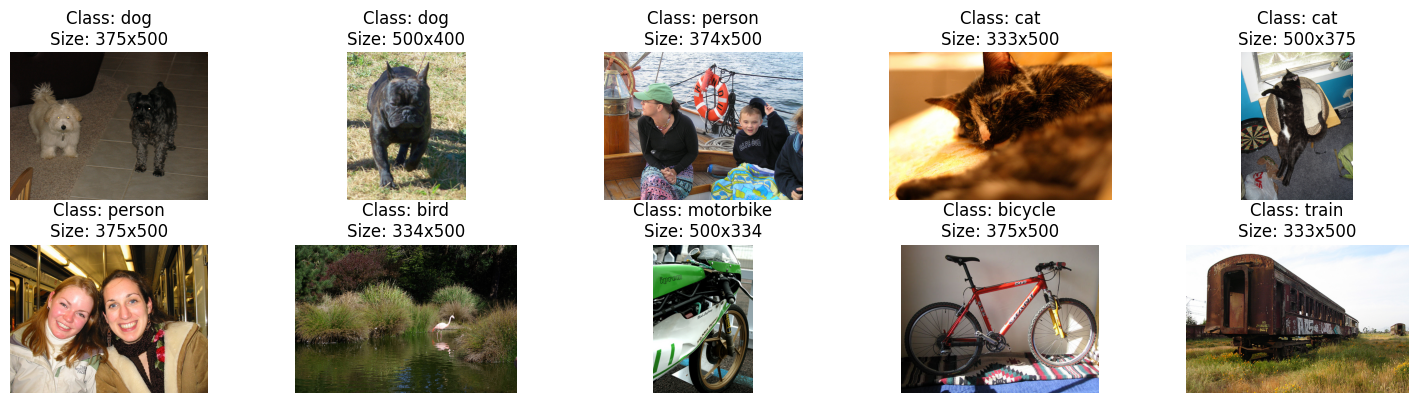

In [11]:
file_rows = df.sample(N_IMAGES_TO_SHOW, random_state=RANDOM_STATE)

images = [np.array(Image.open(f"{IMAGE_DIR}{file}.jpg")) for file in file_rows["file"]]
classes = [c for c in file_rows["class"]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):  # Usa axes.flat per iterare su tutte le sottotrama
    axis.imshow(images[i], cmap='gray')
    axis.axis('off')
    image_size = images[i].shape  # Calcola la dimensione dell'immagine
    axis.set_title(f'Class: {classes[i]}\nSize: {image_size[0]}x{image_size[1]}')

plt.show()

Resized images:

Images loading and preprocessing:

In [12]:
df["filepath"] = df["file"].apply(lambda x: f"{IMAGE_DIR}{x}.jpg")
df.head()

,file,class_id,class,one_hot_class_id,filepath
0,2008_000021,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/trainval/JP...
1,2008_000033,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/trainval/JP...
2,2008_000037,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/trainval/JP...
3,2008_000064,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/trainval/JP...
4,2008_000151,1,aeroplane,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",/content/drive/MyDrive/AML/project/trainval/JP...


In [13]:
labels_array = np.stack(df["one_hot_class_id"].values)
labels_tensor = tf.convert_to_tensor(labels_array, dtype=tf.float32)
labels_tensor

<tf.Tensor: shape=(7567, 20), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [14]:
def load_and_preprocess_image(file_path, label, model_preprocessing:str=RESNET_NAME):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decodifica in formato RGB

    resize = None
    mean = None
    if model_preprocessing == RESNET_NAME:
        resize = RESNET_RESIZE
    elif model_preprocessing == ALEXNET_NAME:
        resize = ALEXNET_RESIZE
    else:
        raise ValueError(f"Unknown model preprocessing: {model_preprocessing}")

    image = tf.image.resize(image, resize)
    image /= 255.0

    return image, label

In [15]:
image_dataset = tf.data.Dataset.from_tensor_slices((df["filepath"], labels_tensor))
image_dataset = image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
image_dataset = image_dataset.shuffle(buffer_size=len(image_dataset), seed=RANDOM_STATE)    # Shuffle so that images are no more ordered by label (for minibatches)

image_dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20,), dtype=tf.float32, name=None))>

## Base model

In [16]:
def create_base_model(input_shape=(224, 224, 3), num_classes=N_CLASSES, dropout_rate=0.5):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dropout(0.2),

        layers.Conv2D(32, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(32, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(64, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),  # Aggiungi dropout dopo lo strato denso
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=EPSILON),
                  metrics=['accuracy'])

    return model

model = create_base_model(input_shape=(224, 224, 3), num_classes=20)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 220, 220, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 106, 106, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 49, 49, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 9, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,620 (2.16 MB)

 Trainable params: 565,620 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
BATCH_SIZE = 32

In [23]:
image_dataset_len = len(df)
train_len = int(TRAIN_SIZE * image_dataset_len)

train_dataset = image_dataset.take(train_len)
val_dataset = image_dataset.skip(train_len)

print(f"Number of training examples: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Number of validation examples: {tf.data.experimental.cardinality(val_dataset)}")

Number of training examples: 6053
Number of validation examples: 1514


In [24]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>)

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stopping

In [26]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 94s 274ms/step - accuracy: 0.1373 - loss: 2.7711 - val_accuracy: 0.1579 - val_loss: 2.7597
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 131s 269ms/step - accuracy: 0.1678 - loss: 2.7013 - val_accuracy: 0.1645 - val_loss: 2.7268
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 143s 270ms/step - accuracy: 0.1679 - loss: 2.6471 - val_accuracy: 0.1453 - val_loss: 2.6435
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 75s 227ms/step - accuracy: 0.1906 - loss: 2.6060 - val_accuracy: 0.1618 - val_loss: 2.6707
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 84s 238ms/step - accuracy: 0.1878 - loss: 2.5797 - val_accuracy: 0.1473 - val_loss: 2.6481
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 78s 241ms/step - accuracy: 0.2158 - loss: 2.5147 - val_accuracy: 0.1308 - val_loss: 2.7274
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 77s 237ms/step - accuracy: 0.2118 - loss: 2.4606 - val_accuracy: 0.1493 - val_loss: 2.6690
Epoch 8/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 88s 252ms/step - accuracy: 0.2271

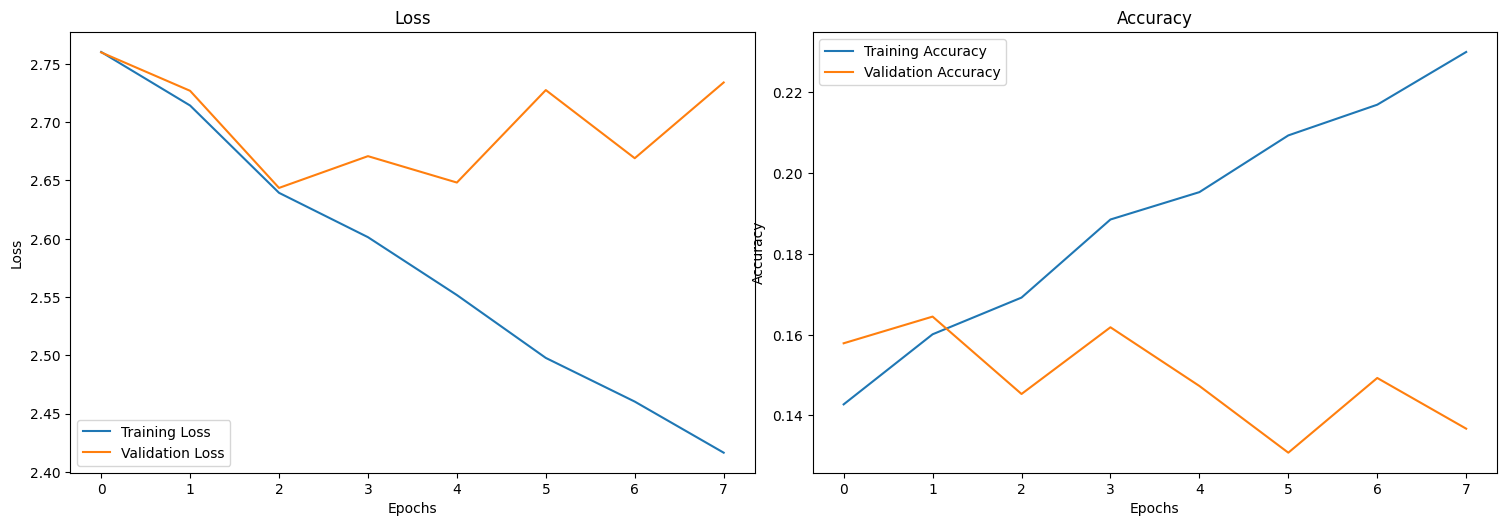

In [27]:
plot_history(history)